# Aligning SEM and STEM images Part 1: Preprocessing
- Load image files
- Crop to same aspect ratio and remove any confusing features like SEM scalebars
- Make images the same dimensions
- Make binary
- Export a stack of real and binary images for part 2

In [1]:
import matplotlib.pyplot as plt
import glob2
import numpy as np
import hyperspy.api as hs

from skimage import filters, transform
from scipy import ndimage

%matplotlib tk
#%matplotlib inline

# Load and crop ICE

In [2]:
ice = hs.load(glob2.glob('ICE*.dm3')[0])

In [3]:
ice

<Signal2D, title: ICE_Br37_Co57_TC_002, dimensions: (|1536, 1103)>

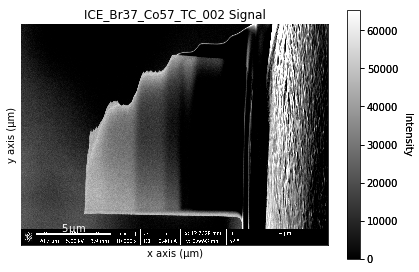

In [4]:
ice.plot()

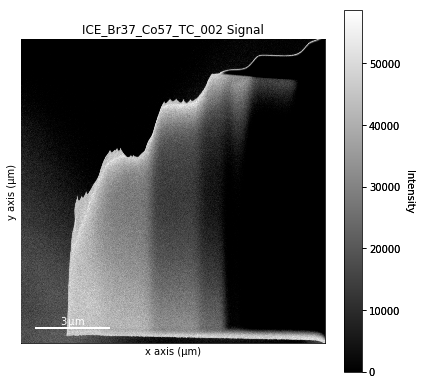

In [5]:
ice.crop_image(top=49, bottom=970, right=1100, left=179)
ice.plot()

In [6]:
ice

<Signal2D, title: ICE_Br37_Co57_TC_002, dimensions: (|921, 921)>

# Load and crop TLD

In [8]:
tld = hs.load(glob2.glob('TC*TLD*003*green*.tif'))

In [9]:
tld

<Signal2D, title: , dimensions: (|1536, 1103)>

In [10]:
tld

<Signal2D, title: , dimensions: (|1536, 1103)>

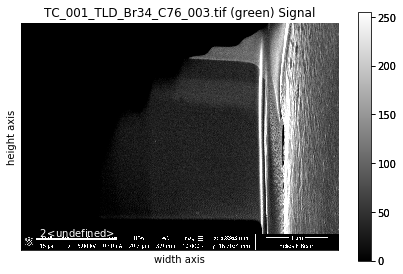

In [11]:
tld.plot()

In [12]:
shift_down = 15
shift_right = 55

tld.crop_image(top=49+shift_down, bottom=970+shift_down, right=1100+shift_right, left=179+shift_right)

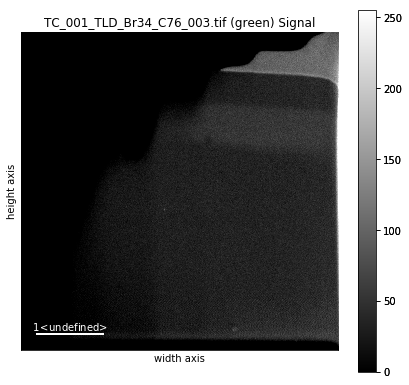

In [13]:
tld.plot()

# Load and correct scale of EELS relative thickness image

In [15]:
directories2 = glob2.glob('Relative*.dm3')
directories2

['Relative thickness_Si_Calib1_postB.dm3']

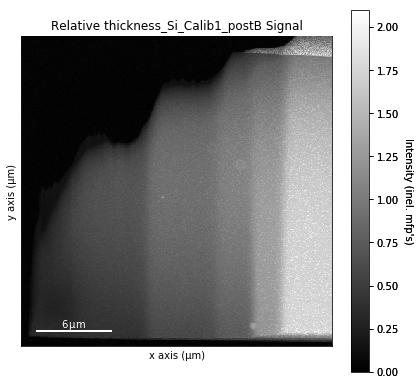

In [16]:
eels = hs.load(directories2[0])
eels.plot()

Sort out EELS scale problem here

In [18]:
px = ice.axes_manager[0].scale
units = ice.axes_manager[0].units
print(str(px) + ' ' + units)

0.013605441898107529 µm


In [19]:
px_eels = hs.load(directories2[0]).axes_manager[0].scale
units_eels = hs.load(directories2[0]).axes_manager[0].units
print(str(px_eels) + ' ' + units_eels)

0.05669747665524483 µm


## pixel size

In [20]:
px_eels/px

4.167264619543983

So the eels pixel is 4x larger than the eels. So pixels need to be made smaller. Up-scale.

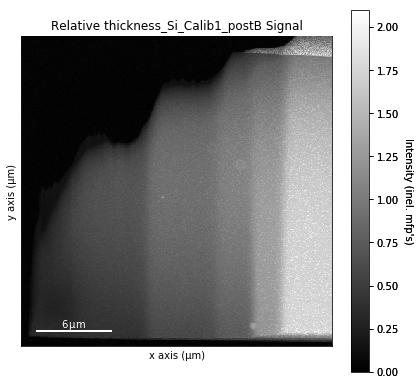

In [22]:
eels.plot()

In [22]:
eels_rescaled = eels.deepcopy()

In [23]:
scaleby = eels.axes_manager[0].scale/px
#scaleby = 0.25

eels_rescaled.data = transform.rescale(eels_rescaled.data, scaleby/2., mode='reflect',
                                       clip=False, preserve_range=True)
eels3 = hs.signals.Signal2D(eels_rescaled.data)

for i in range(2):
    eels3.axes_manager[i].scale = eels_rescaled.axes_manager[i].scale / scaleby # * for downscale
    eels3.axes_manager[i].units = eels_rescaled.axes_manager[i].units

/home/arooney/.local/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/arooney/.local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [27]:
px/eels3.axes_manager[0].scale

1.0000000000000002

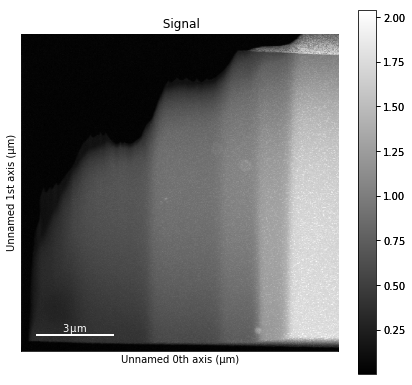

In [28]:
eels3.plot()

In [32]:
print(np.shape(ice))
print(np.shape(eels3))

(921, 921)
(921, 921)


# EELS Filtering

filters.try_all_threshold(eels.data)
plt.savefig('Thresholding of EELS thickness map.png')

## Make some tools for the next few steps

In [36]:
def man_thres_func(image, threshold):
    image.data = image.data > threshold
    return image

def thres_func(image):
    image.data = image.data > filters.threshold_li(image.data)
    return image

def Denoise_EELS(image):
    image.data = np.invert(ndimage.binary_fill_holes(np.invert(image.data)))
    return image

def Fill_ICE(image):
    image.data = ndimage.binary_fill_holes(image.data)
    return image

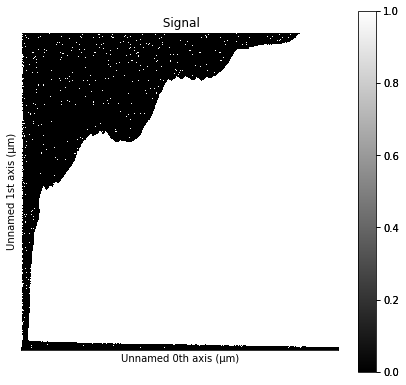

In [34]:
eels_bin = eels3.deepcopy()
eels_bin = man_thres_func(eels_bin, 0.05)
eels_bin.plot()

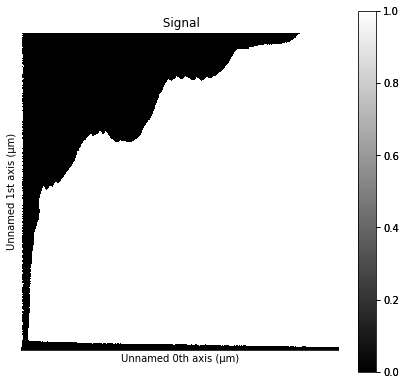

In [35]:
eels_bin = Denoise_EELS(eels_bin)
eels_bin.plot()

# TLD filtering

In [40]:
tld

<Signal2D, title: , dimensions: (|921, 921)>

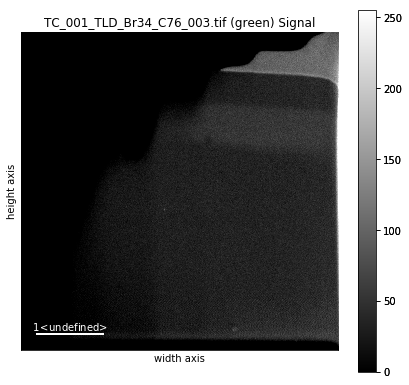

In [41]:
tld.plot()

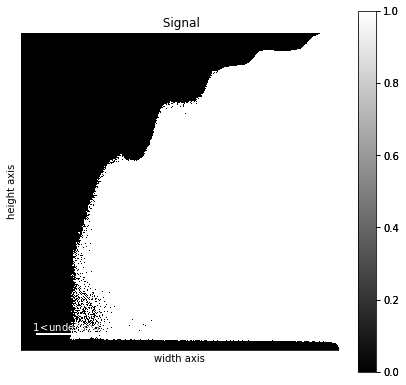

In [42]:
tld_bin = tld.deepcopy()
tld_bin = man_thres_func(tld_bin, 0.000001)
tld_bin.plot()

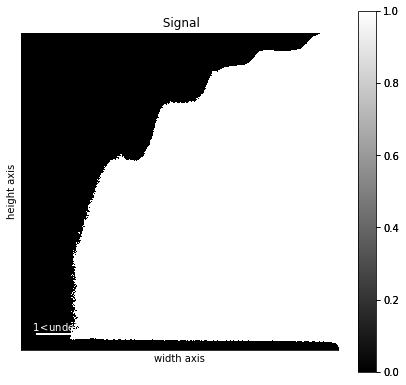

In [43]:
tld_bin = Fill_ICE(tld_bin)
tld_bin.plot()

# ICE filtering

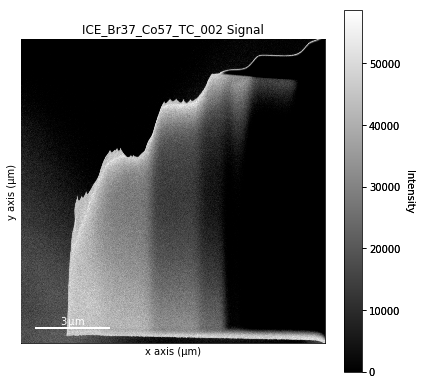

In [44]:
ice.plot()

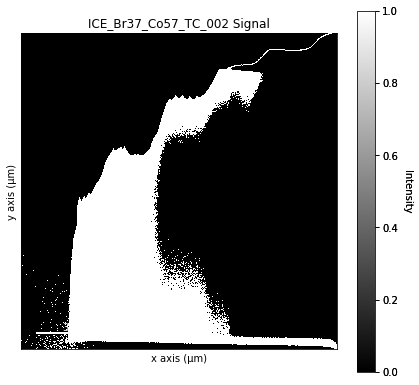

In [45]:
ice_bin = ice.deepcopy()
ice_bin = man_thres_func(ice_bin, 21500.0)
ice_bin.plot()

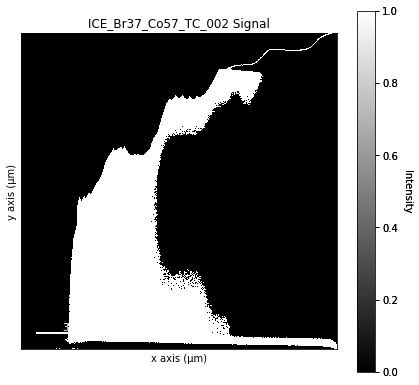

In [46]:
ice_bin = Denoise_EELS(ice_bin)
ice_bin.plot()

In [47]:
def draw_line(image):
    im = np.rot90(image.data)
    im[0:15] = 1.0
    return np.rot90(im, k=3)

ice_bin.data = draw_line(ice_bin)

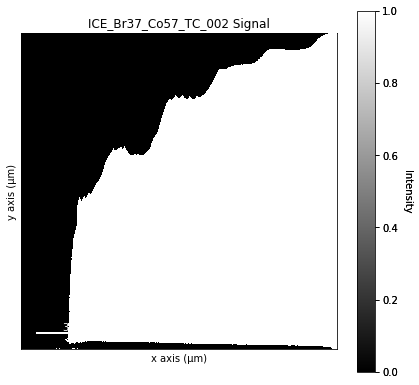

In [48]:
ICE_bin = Fill_ICE(ice_bin)
ICE_bin.plot()

# Save a stack of real images and a stack of binary images

In [49]:
bin_stack = hs.stack([tld_bin, ice_bin, eels_bin])

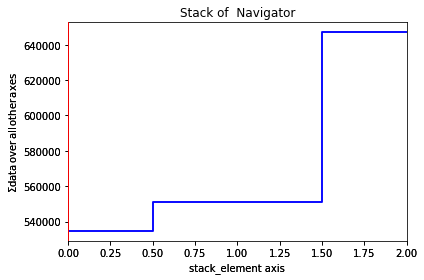

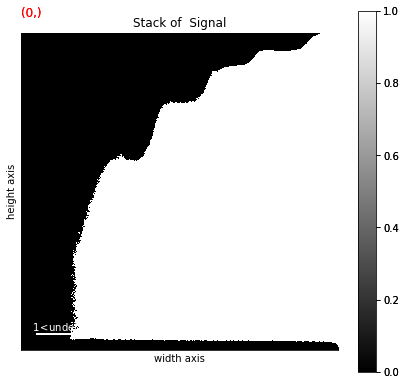

In [50]:
bin_stack.plot()

In [53]:
bin_stack.save('Part 1 Binary images.hdf5')

## Real images

In [51]:
stack = hs.stack([tld, ice, eels3])

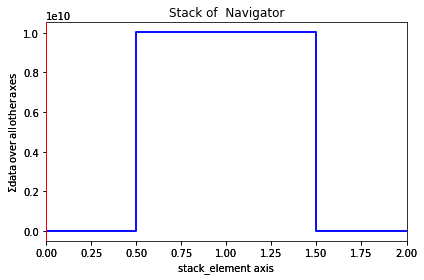

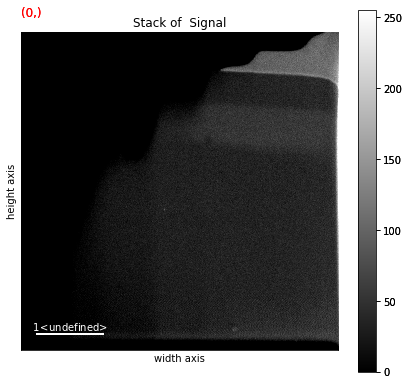

In [52]:
stack.plot()

In [54]:
stack.save('Part 1 real images.hdf5')